In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from scipy.io import loadmat, savemat
from scipy.stats import gaussian_kde
import chaospy as cp
import numpoly
import seaborn as sns

In [2]:
# Chaospy RULE VALIDITY CHECK FUNCTION
# Highly likely some rules in chaospy are not properly implemented and buggy
def check_quadrature_rules(joint_distribution, rules=None, orders=[1, 2], unity_tol = 1e-4, weight_ratio = 1e4):
    """
    Perform checks for quadrature rules on given joint distribution for specified orders.

    :param joint_distribution: A joint probability distribution created using chaospy.
    :param rules: List of quadrature rules expressed as strings. Defaults to the specified list of rules.
    :param orders: List of orders for sparse grids. Defaults to [1, 2].
    """
    # Default list of rules, if not provided
    if rules is None:
        rules = [
            "clenshaw_curtis", "fejer_1", "fejer_2", "gaussian",
            "legendre", "lobatto", "kronrod", "patterson",
            "radau", "leja", "newton_cotes", "genz_keister_16",
            "genz_keister_18", "genz_keister_22", "genz_keister_24"
        ]

    # Dictionary to store valid rules for each order
    valid_rules_dict = {}

    # Loop over the orders and rules and generate quadrature weights
    for order in orders:
        print(f"\nOrder: {order}")
        valid_rules = []
        nan_weight_rules = []
        negative_weight_rules = []
        sum_weight_rules = []
        high_ratio_rules = []

        for rule in rules:
            try:
                nodes, weights = cp.generate_quadrature(order, dist=joint_distribution, rule=rule)

                # Check for nan weights
                if np.any(np.isnan(weights)):
                    nan_weight_rules.append(rule)
                    continue  # Skip to the next iteration

                # Check non-negativity
                if any(weight < 0 for weight in weights):
                    negative_weight_rules.append(rule)
                    continue  # Skip to the next iteration

                # Check sum of weights
                if not np.isclose(sum(weights), 1, rtol=unity_tol):
                    sum_weight_rules.append(rule)
                    continue  # Skip to the next iteration

                # Check ratio of max to min weights
                min_weight = min(weights)
                if min_weight == 0 or max(weights) / min_weight > weight_ratio:
                    high_ratio_rules.append(rule)
                    continue  # Skip to the next iteration

                # If all checks are passed, append the rule to the valid_rules list
                valid_rules.append(rule)

            except Exception as e:
                # Optionally, handle exceptions if needed
                print(f"Error with rule {rule}: {e}")  # For now, print the error and pass to the next iteration

        # Print the lists for the current order
        print("Valid Rules:", valid_rules)
        print("Rules with nan weights:", nan_weight_rules)
        print("Rules with negative weights:", negative_weight_rules)
        print("Rules where weights do not sum to 1:", sum_weight_rules)
        print("Rules with high max/min weight ratio:", high_ratio_rules)

        # Store the valid rules for the current order in the dictionary
        valid_rules_dict[order] = valid_rules

    return valid_rules_dict

In [3]:
# Define a simple 1D distribution (e.g., standard normal)
standard_normal_dist = cp.Normal(0,1)
check_quadrature_rules(standard_normal_dist, orders=[1, 2], unity_tol = 1e-3, weight_ratio = 1e6)


Order: 1
Valid Rules: ['clenshaw_curtis', 'fejer_1', 'gaussian', 'legendre', 'lobatto', 'kronrod', 'radau', 'newton_cotes', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['patterson', 'leja']

Order: 2
Valid Rules: ['gaussian', 'lobatto', 'kronrod', 'radau', 'leja', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['clenshaw_curtis', 'fejer_1', 'legendre', 'patterson', 'newton_cotes']


{1: ['clenshaw_curtis',
  'fejer_1',
  'gaussian',
  'legendre',
  'lobatto',
  'kronrod',
  'radau',
  'newton_cotes',
  'genz_keister_16',
  'genz_keister_18',
  'genz_keister_22',
  'genz_keister_24'],
 2: ['gaussian',
  'lobatto',
  'kronrod',
  'radau',
  'leja',
  'genz_keister_16',
  'genz_keister_18',
  'genz_keister_22',
  'genz_keister_24']}

In [4]:
# Define a standard Gamma distribution
gamma_dist = cp.Gamma(2, 1)  # shape=2, scale=1
gamma_valid_rules = check_quadrature_rules(standard_normal_dist, orders=[1, 2], unity_tol = 1e-3, weight_ratio = 1e6)


Order: 1
Valid Rules: ['clenshaw_curtis', 'fejer_1', 'gaussian', 'legendre', 'lobatto', 'kronrod', 'radau', 'newton_cotes', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['patterson', 'leja']

Order: 2
Valid Rules: ['gaussian', 'lobatto', 'kronrod', 'radau', 'leja', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['clenshaw_curtis', 'fejer_1', 'legendre', 'patterson', 'newton_cotes']


In [5]:
# Define a standard Beta distribution
beta_dist = cp.Beta(2, 5)  # alpha=2, beta=5
beta_valid_rules = check_quadrature_rules(standard_normal_dist, orders=[1, 2], unity_tol = 1e-3, weight_ratio = 1e6)


Order: 1
Valid Rules: ['clenshaw_curtis', 'fejer_1', 'gaussian', 'legendre', 'lobatto', 'kronrod', 'radau', 'newton_cotes', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['patterson', 'leja']

Order: 2
Valid Rules: ['gaussian', 'lobatto', 'kronrod', 'radau', 'leja', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['clenshaw_curtis', 'fejer_1', 'legendre', 'patterson', 'newton_cotes']


In [6]:
#valid_rules = set(gamma_valid_rules[1]) & set(beta_valid_rules[1])
valid_rules = set(gamma_valid_rules[2]) & set(beta_valid_rules[2])
valid_rules = list(valid_rules)
print("Valid Rules:", valid_rules)

Valid Rules: ['gaussian', 'genz_keister_24', 'radau', 'genz_keister_18', 'leja', 'lobatto', 'genz_keister_22', 'kronrod', 'genz_keister_16']


In [7]:
# Define the distributions and create a joint distribution
distributions = [cp.Gamma(2,1), cp.Gamma(1,2), cp.Gamma(3,1), cp.Gamma(2,2), cp.Gamma(1,3), cp.Gamma(3,2), cp.Gamma(2,3), cp.Beta(2, 5)]
joint_distribution = cp.J(*distributions)

valid_rules_7d = check_quadrature_rules(joint_distribution, orders=[1, 2], unity_tol = 1e-3, weight_ratio = 1e5)


Order: 1
Valid Rules: ['gaussian', 'radau', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['clenshaw_curtis', 'fejer_1', 'legendre', 'lobatto', 'kronrod', 'patterson', 'leja', 'newton_cotes']

Order: 2
Error with rule kronrod: Invalid recurrence coefficients can not be used for constructing Gaussian quadrature rule
Valid Rules: []
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['clenshaw_curtis', 'fejer_1', 'gaussian', 'legendre', 'lobatto', 'patterson', 'radau', 'leja', 'newton_cotes', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']


In [8]:
# Define the distributions and create a joint distribution
distributions = [cp.Gamma(2,1), cp.Gamma(1,2), cp.Gamma(3,1), cp.Gamma(2,2), cp.Gamma(1,3), cp.Gamma(3,2), cp.Gamma(2,3), cp.Gamma(3,3)]
joint_distribution = cp.J(*distributions)

valid_rules_7d = check_quadrature_rules(joint_distribution, orders=[1, 2], unity_tol = 1e-3, weight_ratio = 1e5)


Order: 1
Valid Rules: ['gaussian', 'radau', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['clenshaw_curtis', 'fejer_1', 'legendre', 'lobatto', 'kronrod', 'patterson', 'leja', 'newton_cotes']

Order: 2
Error with rule kronrod: Invalid recurrence coefficients can not be used for constructing Gaussian quadrature rule
Valid Rules: []
Rules with nan weights: []
Rules with negative weights: []
Rules where weights do not sum to 1: ['fejer_2']
Rules with high max/min weight ratio: ['clenshaw_curtis', 'fejer_1', 'gaussian', 'legendre', 'lobatto', 'patterson', 'radau', 'leja', 'newton_cotes', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']


EXPERIMENT 1 - SIMPLE 2D CASE

In [9]:
X1 = cp.Gamma(2,1)
X2 = cp.Gamma(1,2)
X = cp.J(X1,X2)
def Y(x1,x2):
    y = 2 - 0.2*x1 + np.sqrt(8)*x1*x2 - 3*x2**2
    return y

In [10]:
# Given list of orders
orders = [1, 2, 3]

# Dictionary to store weights, nodes, and evals
weights = {}
nodes = {}
evals = {}

# Loop through each order in the orders list
for order in orders:
    # Generate sparse grid quadrature nodes and weights using Gaussian rule
    # The Gaussian quadrature rule is specified using cp.Gaussian
    grid_nodes, grid_weights = cp.generate_quadrature(order, X, rule='gaussian', sparse=True)

    # Store the weights and nodes in the respective dictionaries with order as the key
    weights[order] = grid_weights
    nodes[order] = grid_nodes
    evals[order] = Y(*grid_nodes)

In [11]:
surrogates = {}
for order in orders:
    polynomial_basis = cp.expansion.stieltjes(
        order=order,
        dist=X,
        normed=True
    )
    print(nodes[order].shape)
    #print(weights[order].shape)
    #print(evals[order].shape)
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=nodes[order],
        weights=weights[order],
        solves=evals[order]
    )
    surrogates[order] = polynomial_approximation

(2, 5)
(2, 14)
(2, 30)


In [12]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 100
joint_test = X.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs = {}
surrogate_kdes = {}
surrogate_pdf = {}
for order in orders:
    surrogate_model = surrogates[order]
    #print(type(surrogate_model))
    #print(surrogate_model)
    #surrogate_outputs[order] = surrogate_model.__call__(joint_test).astype(float)
    surrogate_outputs[order] = surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:])
    #print(surrogate_outputs[order])
    surrogate_kdes[order] = gaussian_kde(surrogate_outputs[order])
    surrogate_pdf[order] = surrogate_kdes[order](np.linspace(np.min(surrogate_outputs[order]), np.max(surrogate_outputs[order]), 1000))

### SYNTHESIZE NEW DATAPOINTS WITH MONTE CARLO SAMPLING ###
N_test = 1000
MC_test = X.sample(N_test)
MC_outputs = Y(*MC_test)

(2, 100)


(100,)
()
(100,)
()
(100,)
()


Text(0.5, 1.0, 'Sparse Grid Fits Overlaid \non 100 MC Samples')

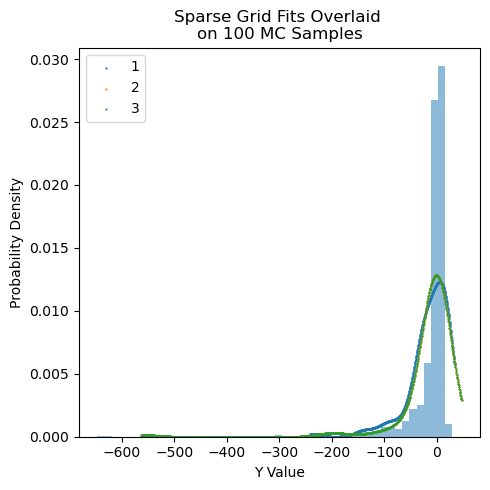

In [13]:
plt.style.use('default')
# Plot surrogate model performance
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, tight_layout=True, figsize=(5,5))

# Plot histograms of random samples for comparision with surrogate model
plt.hist(MC_outputs, bins=50, density=True, alpha=0.5)

# Plot surrogate model pdfs
for order in orders:
    print(surrogate_outputs[order].shape)
    print(surrogates[order].shape)
    plt.scatter(np.linspace(np.min(surrogate_outputs[order]), np.max(surrogate_outputs[order]), 1000), surrogate_pdf[order], label=order, s=1, linewidths=0.5)

plt.xlabel("Y Value")
plt.ylabel("Probability Density")
plt.legend(loc='best')
plt.title('Sparse Grid Fits Overlaid \non 100 MC Samples')

EXPERIMENT 2 - 7D CASE ALL GAMMA


In [14]:
X1 = cp.Gamma(2,1)
X2 = cp.Gamma(1,2)
X3 = cp.Gamma(3,1)
X4 = cp.Gamma(2,2)
X5 = cp.Gamma(1,3)
X6 = cp.Gamma(3,2)
X7 = cp.Gamma(2,3)
XJ7 = cp.J(X1,X2,X3,X4,X5,X6,X7)
def Y7(x1,x2,x3,x4,x5,x6,x7):
    y = 2 - 0.2*x1 + np.sqrt(8)*x1*x2 - 3*x2**2 + 0.5*x3 + 0.1*x4*x5 - 0.2*x5*x6 + 0.3*x6*x7 - 0.4*x7*x1 + 0.5*x1*x2*x3 - 0.6*x2*x3*x4 + 0.7*x3*x4*x5 - 0.8*x4*x5*x6 + 0.9*x5*x6*x7 - 1.0*x6*x7*x1 + 1.1*x7*x1*x2 - 1.2*x1*x2*x3*x4 + 1.3*x2*x3*x4*x5 - 1.4*x3*x4*x5*x6 + 1.5*x4*x5*x6*x7 - 1.6*x5*x6*x7*x1 + 1.7*x6*x7*x1*x2 - 1.8*x7*x1*x2*x3 + 1e-1*x1*x2*x3*x4*x5 - 1e-1*x2*x3*x4*x5*x6 + 1e-1*x3*x4*x5*x6*x7 - 1e-1*x4*x5*x6*x7*x1 + 1e-1*x5*x6*x7*x1*x2 - 1e-1*x6*x7*x1*x2*x3 + 1e-1*x7*x1*x2*x3*x4 + 2e-2*x1*x2*x3*x4*x5*x6 + 2e-2*x2*x3*x4*x5*x6*x7 + 2e-2*x3*x4*x5*x6*x7*x1 + 2e-2*x4*x5*x6*x7*x1*x2 - 2e-2*x5*x6*x7*x1*x2*x3 + 2e-2*x6*x7*x1*x2*x3*x4 + 2e-2*x7*x1*x2*x3*x4*x5 + 3e-3*x1*x2*x3*x4*x5*x6*x7 - 3e-3*x2*x3*x4*x5*x6*x7*x1 + 3e-3*x3*x4*x5*x6*x7*x1*x2 - 3e-3*x4*x5*x6*x7*x1*x2*x3 + 3e-3*x5*x6*x7*x1*x2*x3*x4 - 3e-3*x6*x7*x1*x2*x3*x4*x5 + 3e-3*x7*x1*x2*x3*x4*x5*x6
    #- 4e-4*x1**7 + 4e-4*x2**7 + 4e-4*x3**7 + 4e-4*x4**7 + 4e-4*x5**7 + 4e-4*x6**7 + 4e-4*x7**7
    return y

In [15]:
# Given list of orders
orders7 = [1, 2, 3]

# Dictionary to store weights, nodes, and evals
weights7 = {}
nodes7 = {}
evals7 = {}

# Loop through each order in the orders list
for order in orders:
    # Generate sparse grid quadrature nodes and weights using Gaussian rule
    # The Gaussian quadrature rule is specified using cp.Gaussian
    grid_nodes, grid_weights = cp.generate_quadrature(order, XJ7, rule='gaussian', sparse=True)

    # Store the weights and nodes in the respective dictionaries with order as the key
    weights7[order] = grid_weights
    nodes7[order] = grid_nodes
    evals7[order] = Y7(*grid_nodes)

In [16]:
surrogates7 = {}
for order in orders7:
    polynomial_basis = cp.expansion.stieltjes(
        order=order,
        dist=XJ7,
        normed=True
    )
    print(nodes7[order].shape)
    #print(weights[order].shape)
    #print(evals[order].shape)
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=nodes7[order],
        weights=weights7[order],
        solves=evals7[order]
    )
    surrogates7[order] = polynomial_approximation

(7, 15)
(7, 120)
(7, 680)


In [17]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 100
joint_test = XJ7.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs7 = {}
surrogate_kdes7 = {}
surrogate_pdf7 = {}
for order in orders7:
    surrogate_model7 = surrogates7[order]
    surrogate_outputs7[order] = surrogate_model7(
        q0=joint_test[0,:], q1=joint_test[1,:], q2=joint_test[2,:], q3=joint_test[3,:], q4=joint_test[4,:], q5=joint_test[5,:], q6=joint_test[6,:])
    #print(surrogate_outputs[order])
    surrogate_kdes7[order] = gaussian_kde(surrogate_outputs7[order])
    surrogate_pdf7[order] = surrogate_kdes7[order](np.linspace(np.min(surrogate_outputs7[order]), np.max(surrogate_outputs7[order]), 1000))

### SYNTHESIZE NEW DATAPOINTS WITH MONTE CARLO SAMPLING ###
N_test = 1000
MC_test7 = XJ7.sample(N_test)
MC_outputs7 = Y7(*MC_test7)

(7, 100)


(100,)
()
(100,)
()
(100,)
()


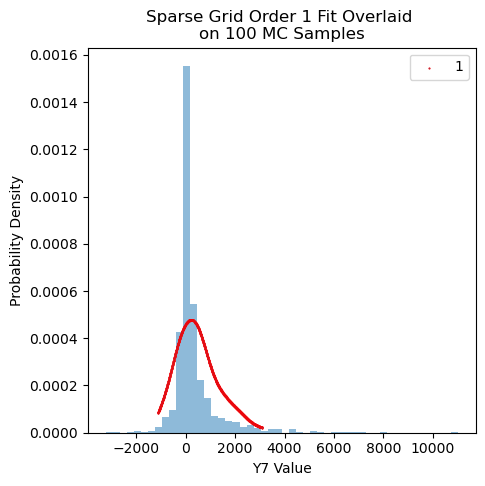

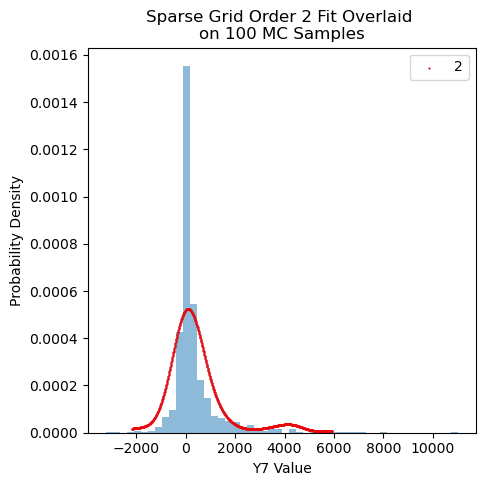

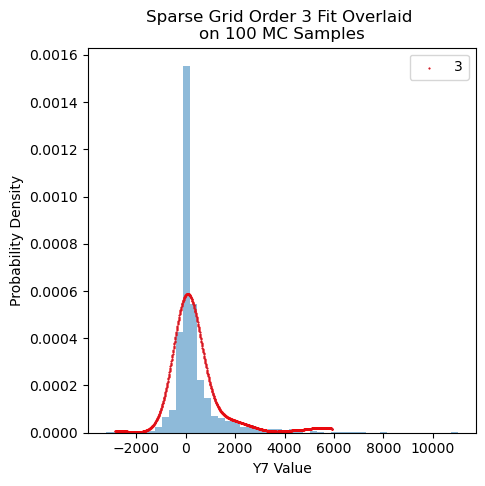

In [18]:
for order in orders7:
    plt.figure(figsize=(5,5))

    # Plot histograms of random samples for comparision with surrogate model
    plt.hist(MC_outputs7, bins=50, density=True, alpha=0.5)

    # Plot surrogate model pdfs
    print(surrogate_outputs7[order].shape)
    print(surrogates7[order].shape)
    plt.scatter(np.linspace(np.min(surrogate_outputs7[order]), np.max(surrogate_outputs7[order]), 1000), surrogate_pdf7[order], label=order, s=1, linewidths=0.5, edgecolors='r')

    plt.xlabel("Y7 Value")
    plt.ylabel("Probability Density")
    plt.legend(loc='best')
    plt.title('Sparse Grid Order '+str(order)+' Fit Overlaid \non 100 MC Samples')

EXPERIMENT 3 - 7D CASE MIXED GAMMA AND BETA

In [19]:
X1 = cp.Gamma(2,1)
X2 = cp.Gamma(1,2)
X3 = cp.Gamma(3,1)
X4 = cp.Gamma(2,2)
X5 = cp.Gamma(1,3)
X6 = cp.Gamma(3,2)
X7 = cp.Beta(2,3)
XJ7 = cp.J(X1,X2,X3,X4,X5,X6,X7)
def Y7(x1,x2,x3,x4,x5,x6,x7):
    y = 2 - 0.2*x1 + np.sqrt(8)*x1*x2 - 3*x2**2 + 0.5*x3 + 0.1*x4*x5 - 0.2*x5*x6 + 0.3*x6*x7 - 0.4*x7*x1 + 0.5*x1*x2*x3 - 0.6*x2*x3*x4 + 0.7*x3*x4*x5 - 0.8*x4*x5*x6 + 0.9*x5*x6*x7 - 1.0*x6*x7*x1 + 1.1*x7*x1*x2 - 1.2*x1*x2*x3*x4 + 1.3*x2*x3*x4*x5 - 1.4*x3*x4*x5*x6 + 1.5*x4*x5*x6*x7 - 1.6*x5*x6*x7*x1 + 1.7*x6*x7*x1*x2 - 1.8*x7*x1*x2*x3 + 1e-1*x1*x2*x3*x4*x5 - 1e-1*x2*x3*x4*x5*x6 + 1e-1*x3*x4*x5*x6*x7 - 1e-1*x4*x5*x6*x7*x1 + 1e-1*x5*x6*x7*x1*x2 - 1e-1*x6*x7*x1*x2*x3 + 1e-1*x7*x1*x2*x3*x4 + 2e-2*x1*x2*x3*x4*x5*x6 + 2e-2*x2*x3*x4*x5*x6*x7 + 2e-2*x3*x4*x5*x6*x7*x1 + 2e-2*x4*x5*x6*x7*x1*x2 - 2e-2*x5*x6*x7*x1*x2*x3 + 2e-2*x6*x7*x1*x2*x3*x4 + 2e-2*x7*x1*x2*x3*x4*x5 # + 3e-3*x1*x2*x3*x4*x5*x6*x7 - 3e-3*x2*x3*x4*x5*x6*x7*x1 + 3e-3*x3*x4*x5*x6*x7*x1*x2 - 3e-3*x4*x5*x6*x7*x1*x2*x3 + 3e-3*x5*x6*x7*x1*x2*x3*x4 - 3e-3*x6*x7*x1*x2*x3*x4*x5 + 3e-3*x7*x1*x2*x3*x4*x5*x6
    #- 4e-4*x1**7 + 4e-4*x2**7 + 4e-4*x3**7 + 4e-4*x4**7 + 4e-4*x5**7 + 4e-4*x6**7 + 4e-4*x7**7
    return y

In [20]:
# Given list of orders
orders7 = [1, 2, 3]

# Dictionary to store weights, nodes, and evals
weights7 = {}
nodes7 = {}
evals7 = {}

# Loop through each order in the orders list
for order in orders:
    # Generate sparse grid quadrature nodes and weights using Gaussian rule
    # The Gaussian quadrature rule is specified using cp.Gaussian
    grid_nodes, grid_weights = cp.generate_quadrature(order, XJ7, rule='gaussian', sparse=True)

    # Store the weights and nodes in the respective dictionaries with order as the key
    weights7[order] = grid_weights
    nodes7[order] = grid_nodes
    evals7[order] = Y7(*grid_nodes)

In [21]:
surrogates7 = {}
for order in orders7:
    polynomial_basis = cp.expansion.stieltjes(
        order=order,
        dist=XJ7,
        normed=True
    )
    print(nodes7[order].shape)
    #print(weights[order].shape)
    #print(evals[order].shape)
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=nodes7[order],
        weights=weights7[order],
        solves=evals7[order]
    )
    surrogates7[order] = polynomial_approximation

(7, 15)
(7, 120)
(7, 680)


In [22]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 100
joint_test = XJ7.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
surrogate_outputs7 = {}
surrogate_kdes7 = {}
surrogate_pdf7 = {}
for order in orders7:
    surrogate_model7 = surrogates7[order]
    surrogate_outputs7[order] = surrogate_model7(
        q0=joint_test[0,:], q1=joint_test[1,:], q2=joint_test[2,:], q3=joint_test[3,:], q4=joint_test[4,:], q5=joint_test[5,:], q6=joint_test[6,:])
    #print(surrogate_outputs[order])
    surrogate_kdes7[order] = gaussian_kde(surrogate_outputs7[order])
    surrogate_pdf7[order] = surrogate_kdes7[order](np.linspace(np.min(surrogate_outputs7[order]), np.max(surrogate_outputs7[order]), 1000))

### SYNTHESIZE NEW DATAPOINTS WITH MONTE CARLO SAMPLING ###
N_test = 1000
MC_test7 = XJ7.sample(N_test)
MC_outputs7 = Y7(*MC_test7)

(7, 100)


(100,)
()
(100,)
()
(100,)
()


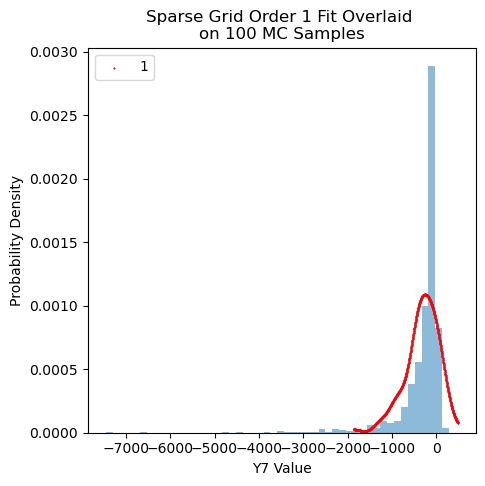

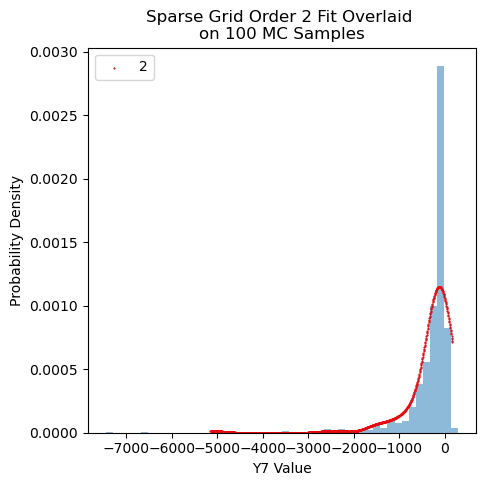

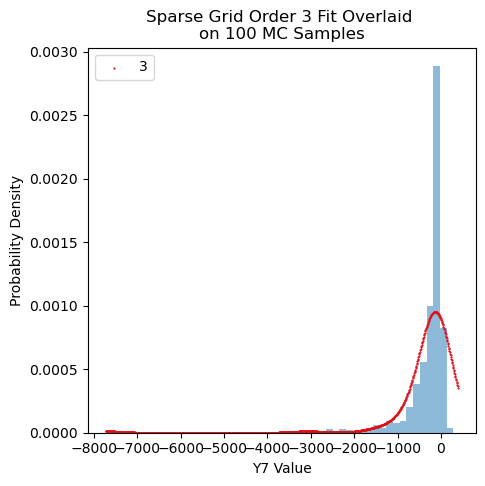

In [23]:
for order in orders7:
    plt.figure(figsize=(5,5))

    # Plot histograms of random samples for comparision with surrogate model
    plt.hist(MC_outputs7, bins=50, density=True, alpha=0.5)

    # Plot surrogate model pdfs
    print(surrogate_outputs7[order].shape)
    print(surrogates7[order].shape)
    plt.scatter(np.linspace(np.min(surrogate_outputs7[order]), np.max(surrogate_outputs7[order]), 1000), surrogate_pdf7[order], label=order, s=1, linewidths=0.5, edgecolors='r')

    plt.xlabel("Y7 Value")
    plt.ylabel("Probability Density")
    plt.legend(loc='best')
    plt.title('Sparse Grid Order '+str(order)+' Fit Overlaid \non 100 MC Samples')

EXPERIMENT 4 - 7D REAL DISTRIBUTIONS

In [24]:
# MATERIAL PROPERTY CONVERSION FORMULAS
E_from_K_and_G = lambda K, G: 9*K*G/(3*K+G)
nu_from_K_and_G = lambda K, G: (3*K-2*G)/(2*(3*K+G))
K_from_E_and_nu = lambda E, nu: E/(3*(1-2*nu))
G_from_E_and_nu = lambda E, nu: E/(2*(1+nu))
c = lambda mu, sigma: mu*(1-mu)/sigma - 1
a = lambda mu, sigma: mu*c(mu, sigma)
b = lambda mu, sigma: (1-mu)*c(mu, sigma)

In [25]:
# Distribution Parameters
np.random.seed(1)
#hard material: steel
#soft material: Epoxy Cure Resin

E_s_mean = 200e6
E_s_std = E_s_mean * 0.08
E_s_a = E_s_mean ** 2 / E_s_std ** 2
E_s_b = E_s_std ** 2 / E_s_mean

E_h_mean = 200e9
E_h_std = E_h_mean * 0.02
E_h_a = E_h_mean ** 2 / E_h_std ** 2
E_h_b = E_h_std ** 2 / E_h_mean

rho_s_mean = 1e3
rho_s_std = rho_s_mean * 0.08
rho_s_a = rho_s_mean ** 2 / rho_s_std ** 2
rho_s_b = rho_s_std ** 2 / rho_s_mean

rho_h_mean = 8e3
rho_h_std = rho_h_mean * 0.02
rho_h_a = rho_h_mean ** 2 / rho_h_std ** 2
rho_h_b = rho_h_std ** 2 / rho_h_mean

pr_s_mean = 0.38
pr_s_std = pr_s_mean * 0.02
pr_s_a = pr_s_mean ** 2 / pr_s_std ** 2
pr_s_b = pr_s_std ** 2 / pr_s_mean

pr_h_mean = 0.28
pr_h_std = pr_h_mean * 0.02
pr_h_a = pr_h_mean ** 2 / pr_h_std ** 2
pr_h_b = pr_h_std ** 2 / pr_h_mean

K_s_mean = K_from_E_and_nu(E_s_mean, pr_s_mean)
K_s_std = K_s_mean * 0.08
K_s_a = K_s_mean ** 2 / K_s_std ** 2
K_s_b = K_s_std ** 2 / K_s_mean

K_h_mean = K_from_E_and_nu(E_h_mean, pr_h_mean)
#K_h_mean = 150e9
K_h_std = K_h_mean * 0.02
K_h_a = K_h_mean ** 2 / K_h_std ** 2
K_h_b = K_h_std ** 2 / K_h_mean

G_s_mean = G_from_E_and_nu(E_s_mean, pr_s_mean)
G_s_std = G_s_mean * 0.08
G_s_a = G_s_mean ** 2 / G_s_std ** 2
G_s_b = G_s_std ** 2 / G_s_mean

G_h_mean = G_from_E_and_nu(E_h_mean, pr_h_mean)
#G_h_mean = 78e9
G_h_std = G_h_mean * 0.02
G_h_a = G_h_mean ** 2 / G_h_std ** 2
G_h_b = G_h_std ** 2 / G_h_mean

geo_fp_mean = 0.025
geo_fp_std = geo_fp_mean * 0.08
geo_fp_var = geo_fp_std ** 2
geo_fp_a = a(geo_fp_mean, geo_fp_var)
geo_fp_b = b(geo_fp_mean, geo_fp_var)

#Create Gamma Distributions
# E_soft_dist = cp.Gamma(E_s_a, E_s_b)
# E_hard_dist = cp.Gamma(E_h_a, E_h_b)
rho_soft_dist = cp.Gamma(rho_s_a, rho_s_b)
rho_hard_dist = cp.Gamma(rho_h_a, rho_h_b)
# pr_soft_dist = cp.Gamma(pr_s_a, pr_s_b)
# pr_hard_dist = cp.Gamma(pr_h_a, pr_h_b)
K_soft_dist = cp.Gamma(K_s_a, K_s_b)
K_hard_dist = cp.Gamma(K_h_a, K_h_b)
G_soft_dist = cp.Gamma(G_s_a, G_s_b)
G_hard_dist = cp.Gamma(G_h_a, G_h_b)
geo_fp_dist = cp.Beta(geo_fp_a, geo_fp_b)
# joint_dist = cp.J(E_soft_dist, E_hard_dist, rho_soft_dist, rho_hard_dist, pr_soft_dist, pr_hard_dist, geo_fp_dist)
joint_dist = cp.J(rho_soft_dist, rho_hard_dist, K_soft_dist, K_hard_dist, G_soft_dist, G_hard_dist, geo_fp_dist)

In [26]:
### GENERATE SPARSE GRID QUADRATURE RULE SAMPLES ###
sparse_degrees = [1, 2, 3]
# For Smolyak sparse grids, computation points won't necessarily be (degree+1)**(input dimensions)
sparse_surrogates = {}
sparse_nodes = {}
sparse_weights = {}
sparse_evals = {}

for d in sparse_degrees:
    nodes, weights = cp.generate_quadrature(d, joint_dist, rule='gaussian', sparse=True)
    sparse_nodes[d] = nodes
    sparse_weights[d] = weights
    sparse_evals[d] = Y7(*sparse_nodes[d])
# print(np.mean(sparse_nodes[3][6]))
# print(sparse_nodes[3].shape)
# print(sparse_weights[3].shape)
# print(sparse_nodes[1])
# print(sparse_weights[1])

In [67]:
### FIT SURROGATE MODELS - SPARSE GRID ###
sparse_surrogates = {}
for degree in sparse_degrees:
    polynomial_basis = cp.expansion.stieltjes(
        order=1,
        dist=joint_dist,
        normed=True
    )
    print(sparse_nodes[degree].shape)
    print(sparse_weights[degree].shape)
    print(sparse_evals[degree].shape)
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=sparse_nodes[degree],
        weights=sparse_weights[degree],
        solves=sparse_evals[degree]
    )
    sparse_surrogates[degree] = polynomial_approximation

(7, 15)
(15,)
(15,)
(7, 120)
(120,)
(120,)
(7, 680)
(680,)
(680,)


In [68]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 100
joint_test = joint_dist.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
sparse_surrogate_outputs = {}
sparse_surrogate_kdes = {}
sparse_surrogate_pdf = {}
for d in sparse_degrees:
    sparse_surrogate_model = sparse_surrogates[d]
    sparse_surrogate_outputs[d] = sparse_surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:], q2=joint_test[2,:], q3=joint_test[3,:], q4=joint_test[4,:], q5=joint_test[5,:], q6=joint_test[6,:])
    #print(surrogate_outputs[order])
    sparse_surrogate_kdes[d] = gaussian_kde(sparse_surrogate_outputs[d])
    sparse_surrogate_pdf[d] = sparse_surrogate_kdes[d](np.linspace(np.min(sparse_surrogate_outputs[d]), np.max(sparse_surrogate_outputs[d]), 1000))

### SYNTHESIZE NEW DATAPOINTS WITH MONTE CARLO SAMPLING ###
N_test = 1000
MC_test = joint_dist.sample(N_test)
MC_outputs = Y7(*MC_test)

(7, 100)


(100,)
()
(100,)
()
(100,)
()


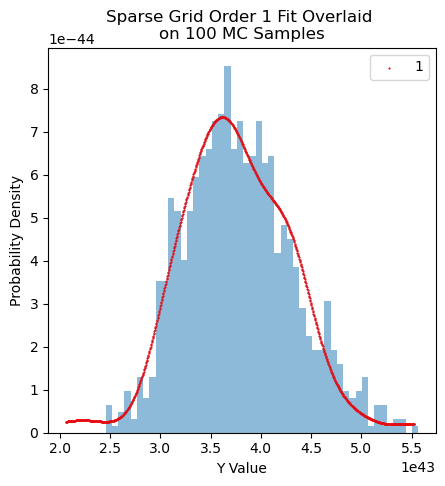

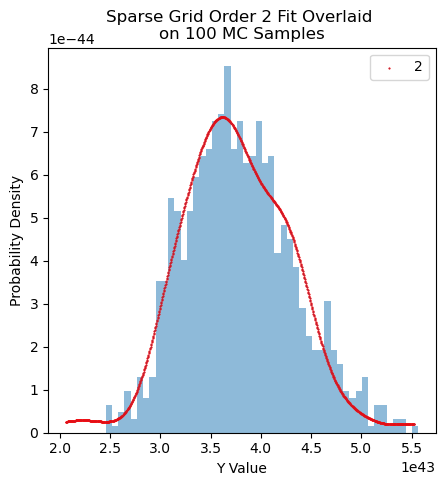

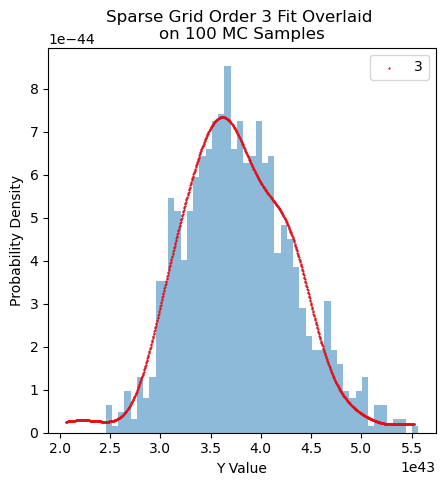

In [69]:
for d in sparse_degrees:
    plt.figure(figsize=(5,5))

    # Plot histograms of random samples for comparision with surrogate model
    plt.hist(MC_outputs, bins=50, density=True, alpha=0.5)

    # Plot surrogate model pdfs
    print(sparse_surrogate_outputs[d].shape)
    print(sparse_surrogates[d].shape)
    plt.scatter(np.linspace(np.min(sparse_surrogate_outputs[d]), np.max(sparse_surrogate_outputs[d]), 1000), sparse_surrogate_pdf[d], label=d, s=1, linewidths=0.5, edgecolors='r')

    plt.xlabel("Y Value")
    plt.ylabel("Probability Density")
    plt.legend(loc='best')
    plt.title('Sparse Grid Order '+str(d)+' Fit Overlaid \non 100 MC Samples')

In [30]:
check_quadrature_rules(joint_dist, orders=[1, 2], unity_tol = 1e-4, weight_ratio = 1e4)


Order: 1


C:\Users\zhang\anaconda3\lib\site-packages\chaospy\quadrature\hypercube.py:305: RuntimeWarning: invalid value encountered in divide
  weights_


Valid Rules: ['gaussian']
Rules with nan weights: ['clenshaw_curtis', 'fejer_1', 'fejer_2', 'legendre', 'patterson', 'newton_cotes']
Rules with negative weights: ['leja']
Rules where weights do not sum to 1: []
Rules with high max/min weight ratio: ['lobatto', 'kronrod', 'radau', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']

Order: 2
Valid Rules: []
Rules with nan weights: ['clenshaw_curtis', 'fejer_1', 'fejer_2', 'legendre', 'newton_cotes']
Rules with negative weights: ['leja']
Rules where weights do not sum to 1: []
Rules with high max/min weight ratio: ['gaussian', 'lobatto', 'kronrod', 'patterson', 'radau', 'genz_keister_16', 'genz_keister_18', 'genz_keister_22', 'genz_keister_24']


{1: ['gaussian'], 2: []}

EXPERIMENT 5 - 7D REAL DISTRIBUTIONS & REAL DATA

In [48]:
bg_size_SG_sets = {}
bg_top_SG_sets = {}
bg_bottom_SG_sets = {}
bg_center_SG_sets = {}

sparse_degrees = [1,2,3]
d_n_map = {1:int(sparse_weights[1].shape[0]), 2:int(sparse_weights[2].shape[0]), 3:int(sparse_weights[3].shape[0])}
for d in sparse_degrees:
    folder_name = 'gamma beta 6+1 inputs quadrature rule sparse study 2'
    #folder_name = 'gamma beta 6+1 inputs sparse grid leja study'
    file_suffix ='_gamma_7d_fp_5%_n'+str(d_n_map[d])+'.mat'

    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    bg_size_SG_sets[d] = bg_size_file['bg_size'][:]
    bg_top_SG_sets[d] = bg_top_file['bg_top'][:]
    bg_bottom_SG_sets[d] = bg_bottom_file['bg_bottom'][:]
    bg_center_SG_sets[d] = (bg_top_SG_sets[d]+bg_bottom_SG_sets[d])/2

In [49]:
bg_size_MC_sets = {}
bg_top_MC_sets = {}
bg_bottom_MC_sets = {}
bg_center_MC_sets = {}

set_N = [100, 1000, 10000, 200, 250, 300]
#set_N = [200, 250, 300]

for N in set_N:
    folder_name = 'gamma beta 6+1 inputs mc study'#+str(N)
    file_suffix = '_gamma_7d_fp_5%_n'+str(N)+'.mat'

    bg_size_file = loadmat(folder_name+'/bg_size'+file_suffix)
    bg_top_file = loadmat(folder_name+'/bg_top'+file_suffix)
    bg_bottom_file = loadmat(folder_name+'/bg_bottom'+file_suffix)

    bg_size_MC_sets[N] = bg_size_file['bg_size'][:]
    bg_top_MC_sets[N] = bg_top_file['bg_top'][:]
    bg_bottom_MC_sets[N] = bg_bottom_file['bg_bottom'][:]
    bg_center_MC_sets[N] = (bg_top_MC_sets[N] + bg_bottom_MC_sets[N])/2

    mat_geo_dist_file = loadmat(folder_name+'/joint_dist_mat_geo_mc_'+str(N)+'.mat')

In [64]:
### FIT SURROGATE MODELS - SPARSE GRID ###
sparse_surrogates = {}
for degree in sparse_degrees:
    print(degree)
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist,
        normed=True
    )
    print(sparse_nodes[degree].shape)
    print(sparse_weights[degree].shape)
    print(sparse_evals[degree].shape)
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=sparse_nodes[degree],
        weights=sparse_weights[degree],
        solves=bg_size_SG_sets[degree]
    )
    sparse_surrogates[degree] = polynomial_approximation

1
(7, 15)
(15,)
(15,)
2
(7, 120)
(120,)
(120,)
3
(7, 680)
(680,)
(680,)


In [62]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 100
joint_test = joint_dist.sample(N_test)
print(joint_test.shape)
#print(joint_test[0])
sparse_surrogate_outputs = {}
sparse_surrogate_kdes = {}
sparse_surrogate_pdf = {}
for d in sparse_degrees:
    sparse_surrogate_model = sparse_surrogates[d]
    sparse_surrogate_outputs[d] = sparse_surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:], q2=joint_test[2,:], q3=joint_test[3,:], q4=joint_test[4,:], q5=joint_test[5,:], q6=joint_test[6,:])
    #print(surrogate_outputs[order])
    sparse_surrogate_kdes[d] = gaussian_kde(sparse_surrogate_outputs[d])
    sparse_surrogate_pdf[d] = sparse_surrogate_kdes[d](np.linspace(np.min(sparse_surrogate_outputs[d]), np.max(sparse_surrogate_outputs[d]), 1000))

(7, 100)


(1, 100)
(1,)
(1, 100)
(1,)
(1, 100)
(1,)


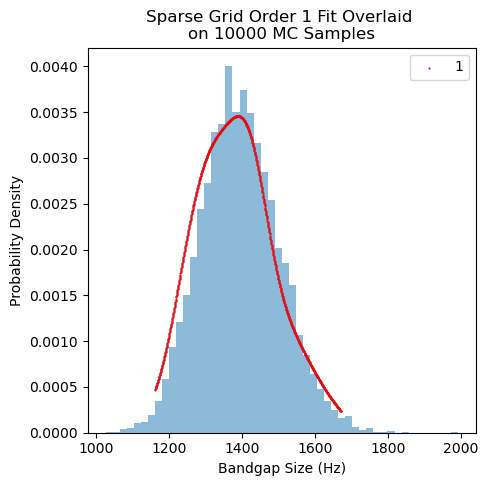

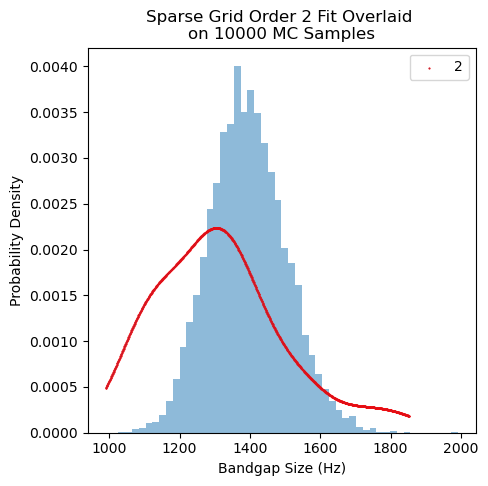

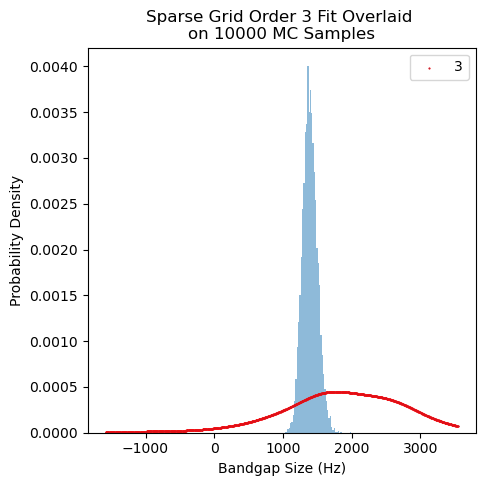

In [63]:
for d in sparse_degrees:
    plt.figure(figsize=(5,5))

    # Plot histograms of random samples for comparision with surrogate model
    plt.hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

    # Plot surrogate model pdfs
    print(sparse_surrogate_outputs[d].shape)
    print(sparse_surrogates[d].shape)
    plt.scatter(np.linspace(np.min(sparse_surrogate_outputs[d]), np.max(sparse_surrogate_outputs[d]), 1000), sparse_surrogate_pdf[d], label=d, s=1, linewidths=0.5, edgecolors='r')

    plt.xlabel("Bandgap Size (Hz)")
    plt.ylabel("Probability Density")
    plt.legend(loc='best')
    plt.title('Sparse Grid Order '+str(d)+' Fit Overlaid \non 10000 MC Samples')

EXPERIMENT 6 - 6D REAL DISTRIBUTIONS & REAL DATA

In [39]:
joint_dist_6D = cp.J(rho_soft_dist, rho_hard_dist, K_soft_dist, K_hard_dist, G_soft_dist, G_hard_dist)

sparse_nodes_6D = {}
sparse_weights_6D = {}
sparse_evals_6D = {}
sparse_surrogates_6D = {}

for degree in sparse_degrees:
    sparse_nodes_6D[degree] = sparse_nodes[degree][:-1,:]
    sparse_weights_6D[degree] = sparse_weights[degree]
    polynomial_basis = cp.expansion.stieltjes(
        order=degree,
        dist=joint_dist_6D,
        normed=True
    )
    print(sparse_nodes_6D[degree].shape)
    print(sparse_weights_6D[degree].shape)
    print(sparse_evals[degree].shape)
    polynomial_approximation = cp.fit_quadrature(
        orth=polynomial_basis,
        nodes=sparse_nodes_6D[degree],
        weights=sparse_weights_6D[degree],
        solves=bg_size_SG_sets[degree]
    )
    sparse_surrogates_6D[degree] = polynomial_approximation

(6, 15)
(15,)
(15,)
(6, 120)
(120,)
(120,)
(6, 680)
(680,)
(680,)


In [40]:
### SYNTHESIZE NEW DATAPOINTS WITH SURROGATE MODELS ###
N_test = 100
joint_test_6D = joint_dist_6D.sample(N_test)
print(joint_test_6D.shape)
#print(joint_test[0])
sparse_surrogate_outputs_6D = {}
sparse_surrogate_kdes_6D = {}
sparse_surrogate_pdf_6D = {}
for d in sparse_degrees:
    sparse_surrogate_model = sparse_surrogates_6D[d]
    sparse_surrogate_outputs_6D[d] = sparse_surrogate_model(
        q0=joint_test[0,:], q1=joint_test[1,:], q2=joint_test[2,:], q3=joint_test[3,:], q4=joint_test[4,:], q5=joint_test[5,:])
    #print(surrogate_outputs[order])
    sparse_surrogate_kdes_6D[d] = gaussian_kde(sparse_surrogate_outputs[d])
    sparse_surrogate_pdf_6D[d] = sparse_surrogate_kdes_6D[d](np.linspace(np.min(sparse_surrogate_outputs_6D[d]), np.max(sparse_surrogate_outputs_6D[d]), 1000))

(6, 100)


(1, 100)
(1,)
(1, 100)
(1,)
(1, 100)
(1,)


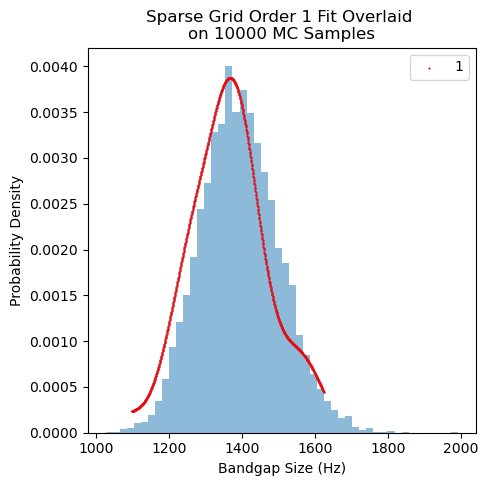

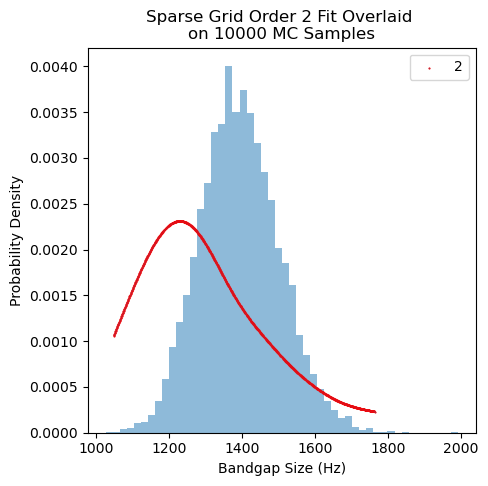

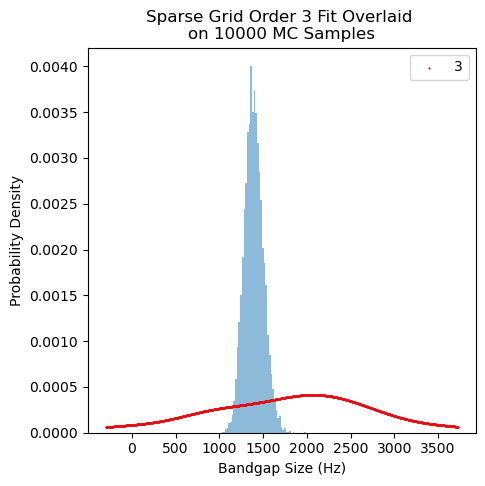

In [41]:
for d in sparse_degrees:
    plt.figure(figsize=(5,5))

    # Plot histograms of random samples for comparision with surrogate model
    plt.hist(bg_size_MC_sets[10000], bins=50, density=True, alpha=0.5)

    # Plot surrogate model pdfs
    print(sparse_surrogate_outputs_6D[d].shape)
    print(sparse_surrogates_6D[d].shape)
    plt.scatter(np.linspace(np.min(sparse_surrogate_outputs_6D[d]), np.max(sparse_surrogate_outputs_6D[d]), 1000), sparse_surrogate_pdf_6D[d], label=d, s=1, linewidths=0.5, edgecolors='r')

    plt.xlabel("Bandgap Size (Hz)")
    plt.ylabel("Probability Density")
    plt.legend(loc='best')
    plt.title('Sparse Grid Order '+str(d)+' Fit Overlaid \non 10000 MC Samples')